<H1>Multivariate prediction of difference in flows</h1>

In [2]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [3]:
directory_list = [
    os.path.join('..', 'Inputs_outputs_excels', 'wsv_rhine_export_with_outliers_balanced.xlsx'),
    os.path.join('..', 'Inputs_outputs_excels', 'wsv_rhine_export - pseudo_huber_29_4_2024.xlsx'),
    os.path.join('..', 'Inputs_outputs_excels', 'wsv_rhine_export_outliers_pseudo_huber.xlsx'),
    os.path.join('..', 'Inputs_outputs_excels', 'rate_of_change_df.xlsx')
]
df = pd.read_excel(directory_list[3])     #This contains the flow.bc (Mass Balance Correction) values

df_mae= df
df = df[1:]
df_input = df

df_input_roc= pd.read_excel(directory_list[3])
df_input_roc= df_input_roc[0:-1]

df_roc=df

df.index = pd.to_datetime(df['Date'],format='%d.%m.%Y %H:%M:%S')

lag_times=14

<h2>Preprocessing data </h2>

<h2>Create a new timeseries table with lag</h2>

In [4]:
features_for_input=['ANDER/flow.bc',
                 #'MENDE/flow.bc',
                 #'OPLAD/flow.bc',
                 #'NEUBR/flow.bc',
                 #'RUHRW/flow.bc',
                 #'SCHER/flow.bc',
                 ]
features_for_input_extended=features_for_input

In [5]:
def lag_creator(df, i):
    df_lag = df.shift(1)  # Shift the DataFrame backwards (upwards in index)
    df_lag = df_lag.rename(columns=lambda col: f"{col}_lag{i}")
    new_cols = df_lag.columns[-1]
    return df_lag, new_cols

for i in range(1, lag_times + 1):
    df_lag, new_cols = lag_creator(df_input[features_for_input], i)
    df_input = pd.concat([df_input, df_lag], axis=1)
    features_for_input_extended.append(new_cols)  # Add all new column names to features_for_input



<h3>Input data</h3>

In [6]:
#df_input=df_input[features_for_input].reset_index(drop=True)
df_input=df_input[features_for_input_extended]
df_input=df_input.reset_index(drop=True)
df_roc=df_roc.reset_index(drop=True)

<h3>Adding periodicity for date</h3>

In [7]:
time=df['Date']
df_time=pd.DataFrame({'Date': time})
df_time['Seconds']=df_time.index.map(pd.Timestamp.timestamp)

#df_time['Day sin']= np.sin(df_time['Seconds']*(2*np.pi/86400))
#df_time['Day cos']= np.cos(df_time['Seconds']*(2*np.pi/86400))
df_time['Year sin']= np.sin(df_time['Seconds']*(2*np.pi/86400/365.2425))
df_time['Year cos']= np.cos(df_time['Seconds']*(2*np.pi/86400/365.2425))
df_time=df_time.drop('Date',axis=1)
df_time=df_time.drop('Seconds',axis=1)
df_time=df_time.reset_index(drop=True)

In [8]:
df_input_concatenated=pd.concat([df_time,df_input,df_roc['Rate of change ANDER/flow.bc']],axis=1,ignore_index=True)
df_input_concatenated=df_input_concatenated[lag_times:]
X_val = df_input_concatenated   #validation dataset

X_val

0         1     2       3       4       5       6       7   \
14   -0.971115  0.238611  1330  1360.0  1410.0  1440.0  1490.0  1510.0   
15   -0.966867  0.255281  1300  1330.0  1360.0  1410.0  1440.0  1490.0   
16   -0.962332  0.271875  1270  1300.0  1330.0  1360.0  1410.0  1440.0   
17   -0.957513  0.288389  1240  1270.0  1300.0  1330.0  1360.0  1410.0   
18   -0.952411  0.304817  1230  1240.0  1270.0  1300.0  1330.0  1360.0   
...        ...       ...   ...     ...     ...     ...     ...     ...   
3647 -0.995657 -0.093093  1160  1180.0  1230.0  1290.0  1390.0  1470.0   
3648 -0.997111 -0.075952  1110  1160.0  1180.0  1230.0  1290.0  1390.0   
3649 -0.998270 -0.058789  1110  1110.0  1160.0  1180.0  1230.0  1290.0   
3650 -0.999134 -0.041608  1080  1110.0  1110.0  1160.0  1180.0  1230.0   
3651 -0.999702 -0.024415  1070  1080.0  1110.0  1110.0  1160.0  1180.0   

          8       9       10      11      12      13      14      15      16  \
14    1550.0  1660.0  1770.0  1870.0  2020.0  2090.0  2000.0  2020.0  2120.0   
15    1510.0  1550.0  1660.0  1770.0  1870.0  2020.0  2090.0  2000.0  2020.0   
16    1490.0  1510.0  1550.0  1660.0  1770.0  1870.0  2020.0  2090.0  2000.0   
17    1440.0  1490.0  1510.0  1550.0  1660.0  1770.0  1870.0  2020.0  2090.0   
18    1410.0  1440.0  1490.0  1510.0  1550.0  1660.0  1770.0  1870.0  2020.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
3647  1610.0  1640.0  1640.0  1700.0  1740.0  1820.0  1950.0  1960.0  1760.0   
3648  1470.0  1610.0  1640.0  1640.0  1700.0  1740.0  1820.0  1950.0  1960.0   
3649  1390.0  1470.0  1610.0  1640.0  1640.0  1700.0  1740.0  1820.0  1950.0   
3650  1290.0  1390.0  1470.0  1610.0  1640.0  1640.0  1700.0  1740.0  1820.0   
3651  1230.0  1290.0  1390.0  1470.0  1610.0  1640.0  1640.0  1700.0  1740.0   

        17  
14   -30.0  
15   -30.0  
16   -30.0  
17   -30.0  
18   -10.0  
...    ...  
3647 -20.0  
3648 -50.0  
3649   0.0  
3650 -30.0  
3651 -10.0  

[3638 rows x 18 columns]

<h3>Creating the label dataframe</h3>

In [9]:
output_attributes=['BONN/flow.obs','BONN/flow.bc',
                    'KOELN/flow.obs','KOELN/flow.bc',
                    'DUESS/flow.obs','DUESS/flow.bc',
                    #'DUISB/flow.obs',
                    #'WESEL/flow.obs',
                    #'REES/flow.obs',
                    #'EMMER/flow.obs'
                    ]
df_output=df[output_attributes]
df_output=df_output[lag_times:]
y_val=df_output


<h2>Splitting data into test, validation and train with window size</h2>

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df_input_concatenated, df_output, test_size=0.33, random_state=42)


In [11]:
# scaler_x=MinMaxScaler(feature_range=(-1,1))
# scaler_y=MinMaxScaler(feature_range=(-1,1))
scaler_x=StandardScaler()
scaler_y=StandardScaler()

X_train_scaled = pd.DataFrame(scaler_x.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler_x.transform(X_test))
X_val_scaled = pd.DataFrame(scaler_x.transform(X_val))

y_train_scaled = pd.DataFrame(scaler_y.fit_transform(y_train))
y_test_scaled = pd.DataFrame(scaler_y.transform(y_test))
y_val_scaled= pd.DataFrame(scaler_y.transform(y_val))

<h1> Feed forward neural network </h1>

<h2> Define the neural network model</h2>

In [12]:
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(100, activation='relu'),
    Dense(y_train_scaled.shape[1])  # Output layer
])

c:\Users\sujan.maharjan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<h2> Compile the model </h2>

In [13]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error',metrics=['mean_absolute_error'])

<h2> Model fit </h2>

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train_scaled, epochs=200, validation_split=0.3)

Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.6775 - mean_absolute_error: 0.5076 - val_loss: 0.1080 - val_mean_absolute_error: 0.2040
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0828 - mean_absolute_error: 0.1827 - val_loss: 0.0551 - val_mean_absolute_error: 0.1420
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0503 - mean_absolute_error: 0.1401 - val_loss: 0.0484 - val_mean_absolute_error: 0.1317
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0477 - mean_absolute_error: 0.1340 - val_loss: 0.0471 - val_mean_absolute_error: 0.1265
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0416 - mean_absolute_error: 0.1237 - val_loss: 0.0458 - val_mean_absolute_error: 0.1246
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0361 - mean_absolute_error: 0.1168 - val_loss: 0.0431 - val_mean_absolute_error: 0.1206
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0386 - mean_absolute_error: 0.1196 - val_loss

<h2>Model evaluation </h2>

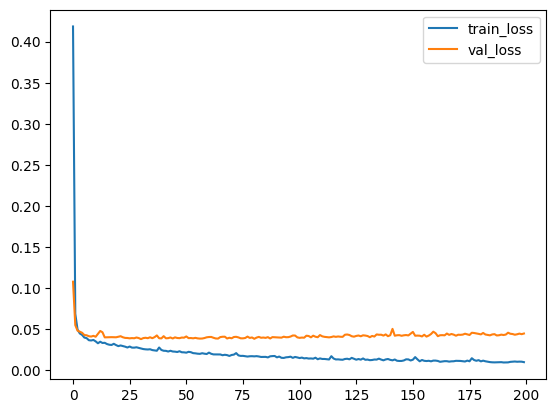

In [15]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.show()

In [16]:
predictions = model.predict(X_test_scaled)
predictions_rescaled = scaler_y.inverse_transform(predictions)
mae_FFNN=mean_absolute_error(y_test, predictions_rescaled)
mse_FFNN=mean_squared_error(y_test, predictions_rescaled)

predictions_FFNN_df=pd.DataFrame(predictions_rescaled)
predictions_FFNN_df.columns=y_test.columns

op=pd.DataFrame(predictions_rescaled)
mae_FFNN, mse_FFNN

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


(28.161676563528527, 2790.831365335976)

<h2>Plotting the validation loss and training loss</h2>

<h2>Validation </h2>

In [17]:
predictions_val = model.predict(X_val_scaled)
predictions_rescaled_val = scaler_y.inverse_transform(predictions_val)

mae_FFNN_val=mean_absolute_error(y_val, predictions_rescaled_val)
mse_FFNN_val=mean_squared_error(y_val, predictions_rescaled_val)

predictions_FFNN_df_val=pd.DataFrame(predictions_rescaled_val)
predictions_FFNN_df_val.columns=y_val.columns

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<h2>Evaluation metrics for each and every label</h2>

In [18]:
mae_dict_FFNN_val = {}
mse_dict_FFNN_val = {}
for column in predictions_FFNN_df_val.columns:
    mae_val = mean_absolute_error(y_val[column], predictions_FFNN_df_val[column])
    mse_val = mean_squared_error(y_val[column], predictions_FFNN_df_val[column])
    mae_dict_FFNN_val[column] = mae_val
    mse_dict_FFNN_val[column] = mse_val

print("MAE for each column:")
for column, mae_val in mae_dict_FFNN_val.items():
    print(f"{column}: {mae_val}")

print("\nMSE for each column:")
for column, mse_val in mse_dict_FFNN_val.items():
    print(f"{column}: {mse_val}")


MAE for each column:
BONN/flow.obs: 31.389126937555833
BONN/flow.bc: 10.209777922768321
KOELN/flow.obs: 37.26340327333657
KOELN/flow.bc: 7.7591239430949575
DUESS/flow.obs: 41.17176626749652
DUESS/flow.bc: 7.395421791003483

MSE for each column:
BONN/flow.obs: 2103.943519691627
BONN/flow.bc: 253.38636582785372
KOELN/flow.obs: 3441.4654622771677
KOELN/flow.bc: 167.40563739554068
DUESS/flow.obs: 4239.7079053810285
DUESS/flow.bc: 106.43873126188143


<h1>Linear Regression</h1>

In [19]:
regressor_bonn= LinearRegression()
model_linear= regressor_bonn.fit(X_val.iloc[:,[-1]],y_val.iloc[:,[1]])
prediction_linear_bonn= regressor_bonn.predict(X_val.iloc[:,[-1]]).reshape(-1)

regressor_koeln= LinearRegression()
model_linear= regressor_koeln.fit(X_val.iloc[:,[-1]],y_val.iloc[:,[3]])
prediction_linear_koeln= regressor_koeln.predict(X_val.iloc[:,[-1]]).reshape(-1)

regressor_duess= LinearRegression()
model_linear= regressor_duess.fit(X_val.iloc[:,[-1]],y_val.iloc[:,[5]])
prediction_linear_duess= regressor_duess.predict(X_val.iloc[:,[-1]]).reshape(-1)

prediction_linear=[prediction_linear_bonn,prediction_linear_koeln, prediction_linear_duess]

mae_val_lin = mean_absolute_error(y_val.iloc[:,[0]], prediction_linear[0])
mse_val_lin = mean_squared_error(y_val.iloc[:,[0]], prediction_linear[0])

<h2> Bonn Output visualization</h2>

In [23]:
i=0
data = {
    'Date': y_val.index,
    'Discharge MIMO FFNN': predictions_rescaled_val[:, 0],
    'Flow observed': np.array(y_val)[:, 0],
    'MBC MIMO FFNN': predictions_rescaled_val[:, 1],
    'MBC Lin Reg': prediction_linear[0],
    'MBC DA': np.array(y_val)[:, 1],
}

df_plot_val = pd.DataFrame(data)
df_plot_val['Random error FFNN'] = df_plot_val['MBC DA'] - df_plot_val['MBC MIMO FFNN']
df_plot_val['Random error LR'] = df_plot_val['MBC DA'] - df_plot_val['MBC Lin Reg']

In [21]:


# Create subplots
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    subplot_titles=(
        'Discharge prediction using FFNN ' + df_output.columns[i],
        'MBC prediction ' + df_output.columns[i],
        'Random error ' + df_output.columns[i]
    ),
    vertical_spacing=0.05
)

# Add traces for the first subplot
fig.append_trace(
    go.Scatter(x=df_plot_val['Date'], 
               y=df_plot_val['Discharge MIMO FFNN'],
               mode='lines',
               name='Discharge MIMO FFNN',
               legendgroup='1',
               marker={'color': 'red'}),
    row=1, col=1
)
fig.append_trace(
    go.Scatter(x=df_plot_val['Date'],
               y=df_plot_val['Flow observed'],
               mode='lines',
               name='Flow observed',
               legendgroup='1',
               marker={'color': 'green'}),
    row=1, col=1
)

# Add traces for the second subplot
fig.append_trace(
    go.Scatter(x=df_plot_val['Date'],
               y=df_plot_val['MBC MIMO FFNN'],
               mode='lines',
               name='MBC MIMO FFNN',
               legendgroup='2',
               marker={'color': 'red'}),
    row=2, col=1
)
fig.append_trace(
    go.Scatter(x=df_plot_val['Date'],
               y=df_plot_val['MBC DA'],
               mode='lines',
               name='MBC DA',
               legendgroup='2',
               marker={'color': 'blue'}),
    row=2, col=1
)
fig.append_trace(
    go.Scatter(x=df_plot_val['Date'],
               y=df_plot_val['MBC Lin Reg'],
               mode='lines',
               name='MBC Lin Reg',
               legendgroup='2',
               marker={'color': 'goldenrod'}),
    row=2, col=1
)

# Add traces for the third subplot

fig.append_trace(
    go.Scatter(x=df_plot_val['Date'],
               y=df_plot_val['MBC DA'],
               mode='lines',
               name='MBC DA',
               legendgroup='3',
               marker={'color': 'blue'}),
    row=3, col=1
)
fig.append_trace(
    go.Scatter(x=df_plot_val['Date'],
               y=df_plot_val['Random error LR'],
               mode='lines',
               name='Random error LR',
               legendgroup='3',
               marker={'color': 'goldenrod'}),
    row=3, col=1
)
fig.append_trace(
    go.Scatter(x=df_plot_val['Date'],
               y=df_plot_val['Random error FFNN'],
               mode='lines',
               name='Random error FFNN',
               legendgroup='3',
               marker={'color': 'red'}),
    row=3, col=1
)

# Update layout
fig.update_layout(
    height=1100, width=900,
    template='simple_white',
    xaxis=dict(showline=True, linewidth=1, linecolor='black', mirror=True),
    yaxis=dict(showline=True, linewidth=1, linecolor='black', mirror=True),
    xaxis2=dict(showline=True, linewidth=1, linecolor='black', mirror=True),
    yaxis2=dict(showline=True, linewidth=1, linecolor='black', mirror=True),
    xaxis3=dict(showline=True, linewidth=1, linecolor='black', mirror=True),
    yaxis3=dict(showline=True, linewidth=1, linecolor='black', mirror=True),
    legend_tracegroupgap = 270,
    legend={
        'x': 0.75, # x position
        'y': 0.99, # y position
        'bgcolor': 'rgba(0, 0, 0, 0)'
    }
)

fig.update_xaxes(title_text="Date", row=3, col=1)  # Example for updating x-axis label of the third subplot
fig.update_yaxes(title_text="Discharge (m³/s)", row=1, col=1)
fig.update_yaxes(title_text="MBC (m³/s)", row=2, col=1)
fig.update_yaxes(title_text="Discharge (m³/s)", row=3, col=1)

fig.show()

<h3>Visualization matplotlib format full time</h3>

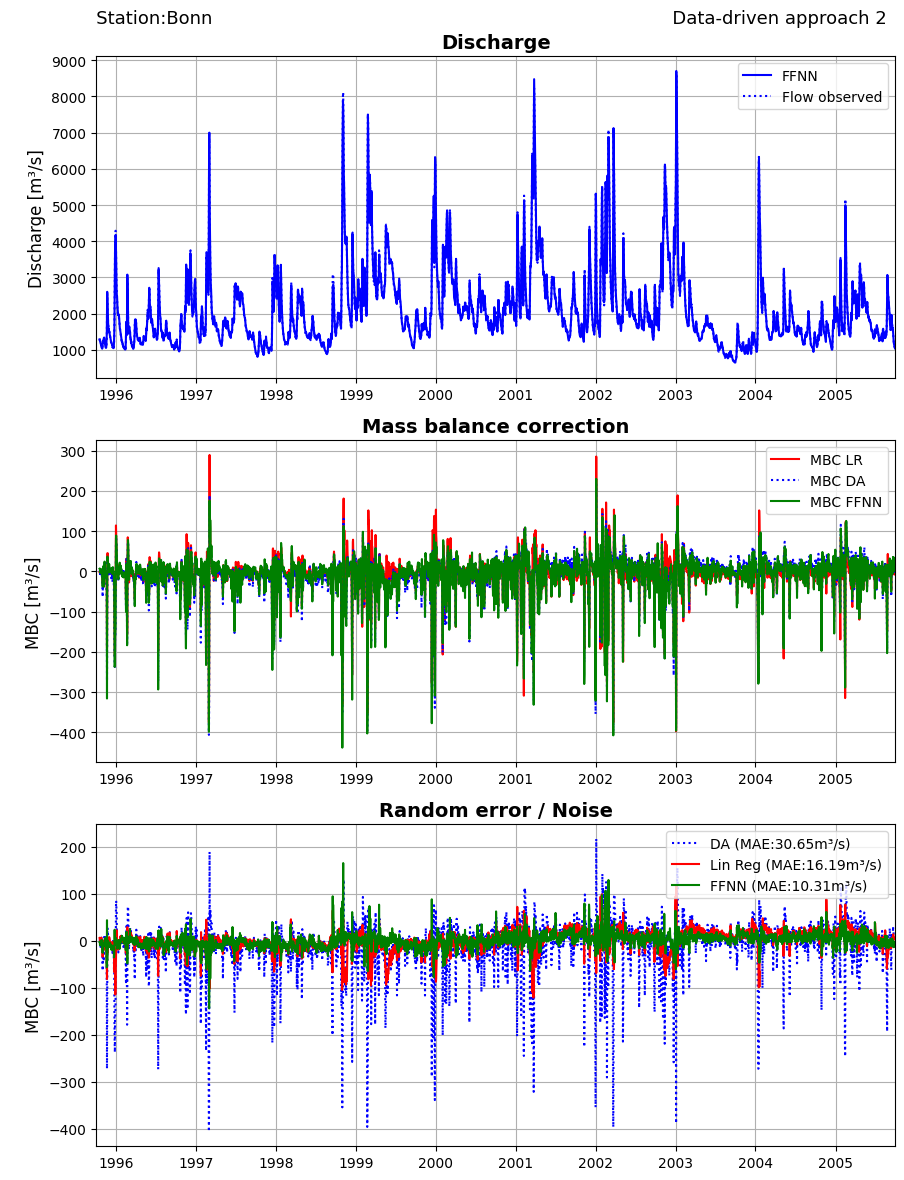

In [342]:

start_date='01/10/1995'
end_date='30/09/2005'

start_date_obj = datetime.strptime(start_date, '%d/%m/%Y')
end_date_obj = datetime.strptime(end_date, '%d/%m/%Y')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 12))
fig.suptitle('               Station:Bonn                                                                                Data-driven approach 2', fontsize=13,  x=0.0, ha='left')

ax1.plot(df_plot_val['Date'], df_plot_val['Discharge MIMO FFNN'], label='FFNN', color='blue')
ax1.plot(df_plot_val['Date'], df_plot_val['Flow observed'], label='Flow observed', linestyle='dotted', color='Blue')
ax1.set_title('Discharge', fontsize=14, fontweight='bold')
ax1.set_ylabel('Discharge [m³/s]', fontsize=12)
ax1.set_xlim(start_date_obj, end_date_obj)
ax1.grid(True)
ax1.legend(loc='upper right')

ax2.plot(df_plot_val['Date'], df_plot_val['MBC Lin Reg'], label='MBC LR', color='red')
ax2.plot(df_plot_val['Date'], df_plot_val['MBC DA'], label='MBC DA', color='blue', linestyle='dotted')
ax2.plot(df_plot_val['Date'], df_plot_val['MBC MIMO FFNN'], label='MBC FFNN', color='green')
ax2.set_title('Mass balance correction', fontsize=14, fontweight='bold')
ax2.set_ylabel('MBC [m³/s]', fontsize=12)
ax2.set_xlim(start_date_obj, end_date_obj)
ax2.grid(True)
ax2.legend(loc='upper right')

ax3.plot(df_plot_val['Date'], df_plot_val['MBC DA'], label=f'DA (MAE:{df_mae.iloc[0]['BONN/MAE']:.2f}m³/s)', color='blue', linestyle='dotted')
ax3.plot(df_plot_val['Date'], df_plot_val['Random error LR'], label=f'Lin Reg (MAE:{df_mae.iloc[0]['BONN/LR']:.2f}m³/s)', color='red')
ax3.plot(df_plot_val['Date'], df_plot_val['Random error FFNN'], label=f'FFNN (MAE:{mae_dict_FFNN_val['BONN/flow.bc']:.2f}m³/s)', color='green')
ax3.set_title('Random error / Noise', fontsize=14, fontweight='bold')
ax3.set_ylabel('MBC [m³/s]', fontsize=12)
ax3.set_xlim(start_date_obj, end_date_obj)
ax3.grid(True)
ax3.legend(loc='upper right')

plt.tight_layout()
plt.savefig('01_Bonn_Full_time.png')
plt.show()


<h3>Visualization matplotlib format limilted time</h3>

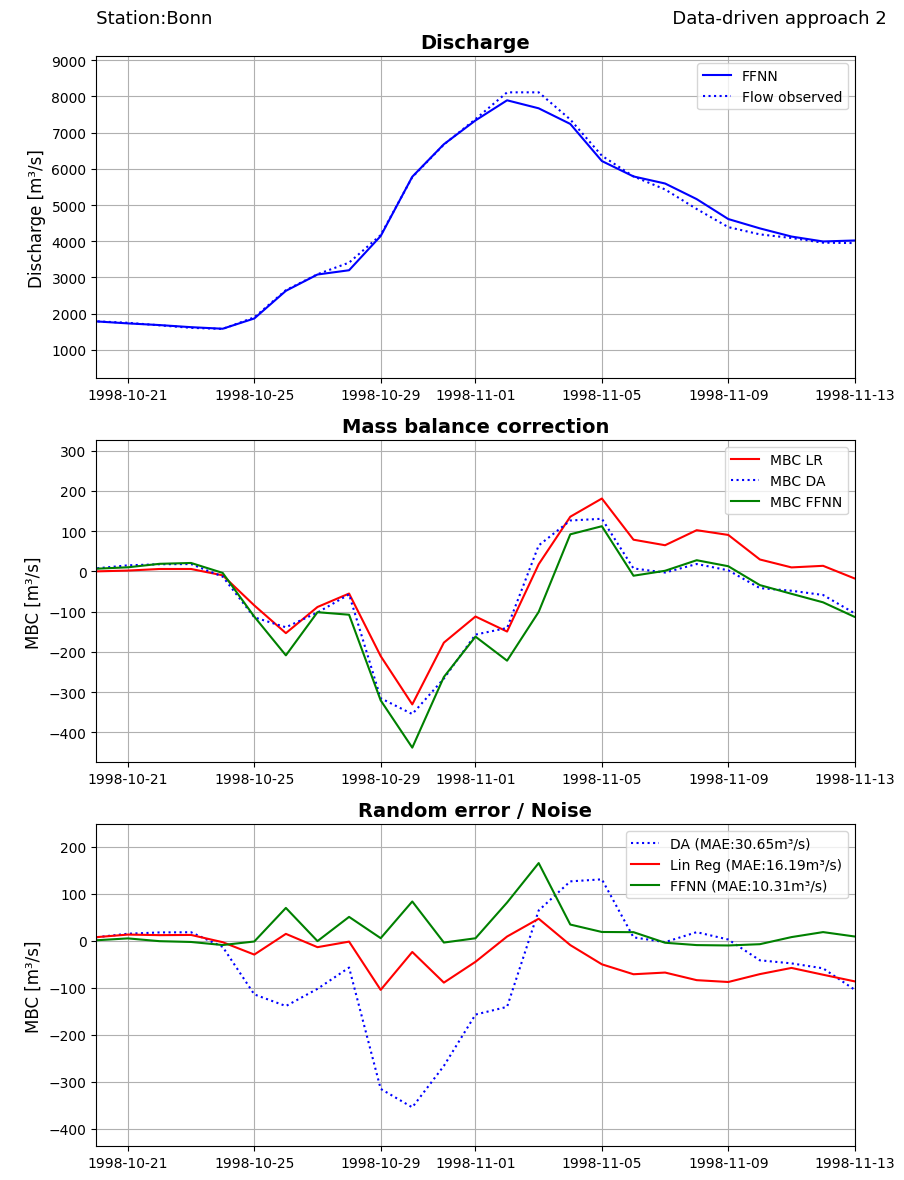

In [334]:

start_date='20/10/1998'
end_date='13/11/1998'

start_date_obj = datetime.strptime(start_date, '%d/%m/%Y')
end_date_obj = datetime.strptime(end_date, '%d/%m/%Y')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 12))
fig.suptitle('               Station:Bonn                                                                                Data-driven approach 2', fontsize=13,  x=0.0, ha='left')
ax1.plot(df_plot_val['Date'], df_plot_val['Discharge MIMO FFNN'], label='FFNN', color='blue')
ax1.plot(df_plot_val['Date'], df_plot_val['Flow observed'], label='Flow observed', linestyle='dotted', color='Blue')
ax1.set_title('Discharge', fontsize=14, fontweight='bold')
ax1.set_ylabel('Discharge [m³/s]', fontsize=12)
ax1.set_xlim(start_date_obj, end_date_obj)
ax1.grid(True)
ax1.legend(loc='upper right')

ax2.plot(df_plot_val['Date'], df_plot_val['MBC Lin Reg'], label='MBC LR', color='red')
ax2.plot(df_plot_val['Date'], df_plot_val['MBC DA'], label='MBC DA', color='blue', linestyle='dotted')
ax2.plot(df_plot_val['Date'], df_plot_val['MBC MIMO FFNN'], label='MBC FFNN', color='green')
ax2.set_title('Mass balance correction', fontsize=14, fontweight='bold')
ax2.set_ylabel('MBC [m³/s]', fontsize=12)
ax2.set_xlim(start_date_obj, end_date_obj)
ax2.grid(True)
ax2.legend(loc='upper right')

ax3.plot(df_plot_val['Date'], df_plot_val['MBC DA'], label=f'DA (MAE:{df_mae.iloc[0]['BONN/MAE']:.2f}m³/s)', color='blue', linestyle='dotted')
ax3.plot(df_plot_val['Date'], df_plot_val['Random error LR'], label=f'Lin Reg (MAE:{df_mae.iloc[0]['BONN/LR']:.2f}m³/s)', color='red')
ax3.plot(df_plot_val['Date'], df_plot_val['Random error FFNN'], label=f'FFNN (MAE:{mae_dict_FFNN_val['BONN/flow.bc']:.2f}m³/s)', color='green')
ax3.set_title('Random error / Noise', fontsize=14, fontweight='bold')
ax3.set_ylabel('MBC [m³/s]', fontsize=12)
ax3.set_xlim(start_date_obj, end_date_obj)
ax3.grid(True)
ax3.legend(loc='upper right')

plt.tight_layout()
plt.savefig('07_Bonn_selected_time_1.png')
plt.show()

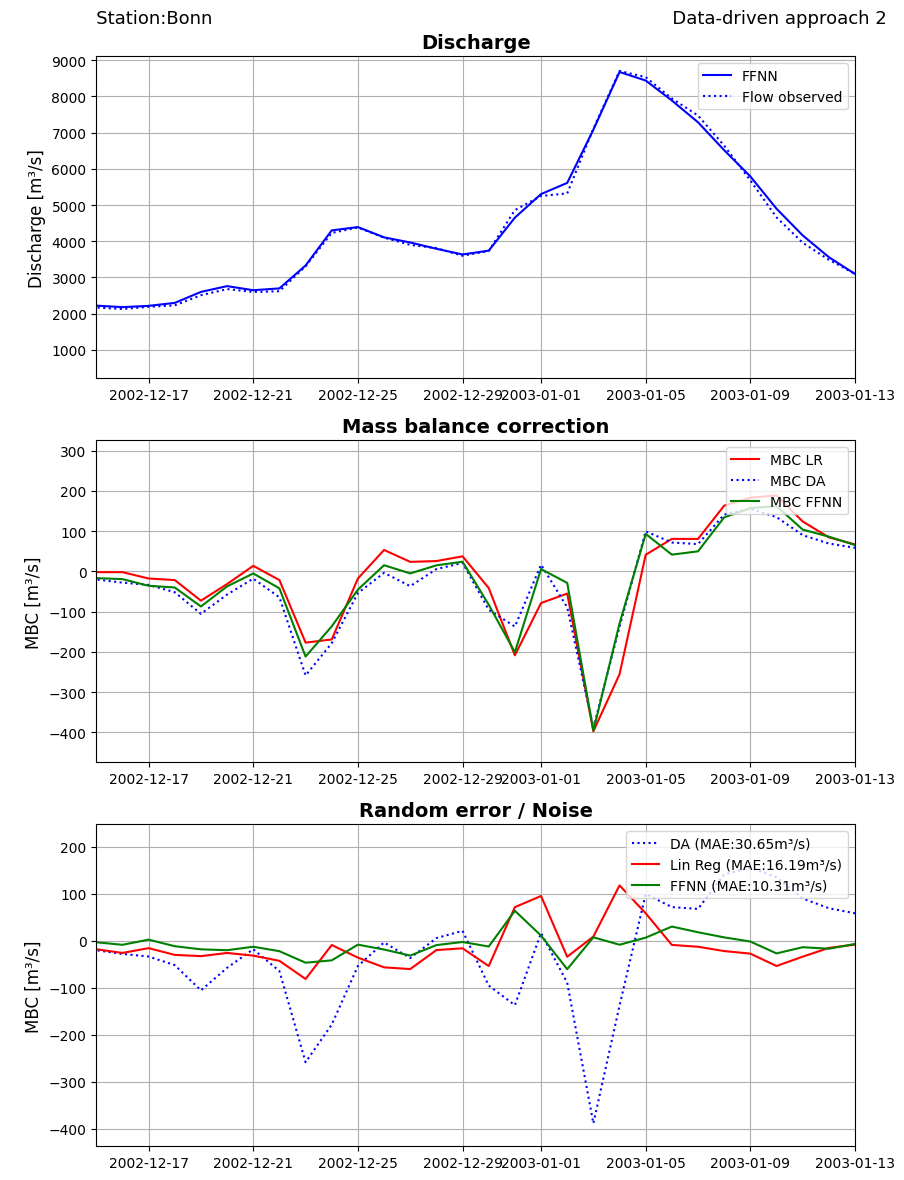

In [335]:

start_date='15/12/2002'
end_date='13/01/2003'

start_date_obj = datetime.strptime(start_date, '%d/%m/%Y')
end_date_obj = datetime.strptime(end_date, '%d/%m/%Y')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 12))
fig.suptitle('               Station:Bonn                                                                                Data-driven approach 2', fontsize=13,  x=0.0, ha='left')

ax1.plot(df_plot_val['Date'], df_plot_val['Discharge MIMO FFNN'], label='FFNN', color='blue')
ax1.plot(df_plot_val['Date'], df_plot_val['Flow observed'], label='Flow observed', linestyle='dotted', color='Blue')
ax1.set_title('Discharge', fontsize=14, fontweight='bold')
ax1.set_ylabel('Discharge [m³/s]', fontsize=12)
ax1.set_xlim(start_date_obj, end_date_obj)
ax1.grid(True)
ax1.legend(loc='upper right')

ax2.plot(df_plot_val['Date'], df_plot_val['MBC Lin Reg'], label='MBC LR', color='red')
ax2.plot(df_plot_val['Date'], df_plot_val['MBC DA'], label='MBC DA', color='blue', linestyle='dotted')
ax2.plot(df_plot_val['Date'], df_plot_val['MBC MIMO FFNN'], label='MBC FFNN', color='green')
ax2.set_title('Mass balance correction', fontsize=14, fontweight='bold')
ax2.set_ylabel('MBC [m³/s]', fontsize=12)
ax2.set_xlim(start_date_obj, end_date_obj)
ax2.grid(True)
ax2.legend(loc='upper right')

ax3.plot(df_plot_val['Date'], df_plot_val['MBC DA'], label=f'DA (MAE:{df_mae.iloc[0]['BONN/MAE']:.2f}m³/s)', color='blue', linestyle='dotted')
ax3.plot(df_plot_val['Date'], df_plot_val['Random error LR'], label=f'Lin Reg (MAE:{df_mae.iloc[0]['BONN/LR']:.2f}m³/s)', color='red')
ax3.plot(df_plot_val['Date'], df_plot_val['Random error FFNN'], label=f'FFNN (MAE:{mae_dict_FFNN_val['BONN/flow.bc']:.2f}m³/s)', color='green')
ax3.set_title('Random error / Noise', fontsize=14, fontweight='bold')
ax3.set_ylabel('MBC [m³/s]', fontsize=12)
ax3.set_xlim(start_date_obj, end_date_obj)
ax3.grid(True)
ax3.legend(loc='upper right')

plt.tight_layout()
plt.savefig('07_Bonn_selected_time_2.png')
plt.show()

<h2>Koeln outputs</h2>

In [25]:
i=1

mae_val_lin = mean_absolute_error(y_val.iloc[:,[1]], prediction_linear[i])
mse_val_lin = mean_squared_error(y_val.iloc[:,[1]], prediction_linear[i])

data = {
    'Date': y_val.index,
    'Discharge MIMO FFNN': predictions_rescaled_val[:, 2],
    'Flow observed': np.array(y_val)[:, 2],
    'MBC MIMO FFNN': predictions_rescaled_val[:, 3],
    'MBC Lin Reg': prediction_linear[1],
    'MBC DA': np.array(y_val)[:, 3],
}

df_plot_val = pd.DataFrame(data)
df_plot_val['Random error FFNN'] = df_plot_val['MBC DA'] - df_plot_val['MBC MIMO FFNN']
df_plot_val['Random error LR'] = df_plot_val['MBC DA'] - df_plot_val['MBC Lin Reg']

<h3>Visualization matplotlib format full time</h3>

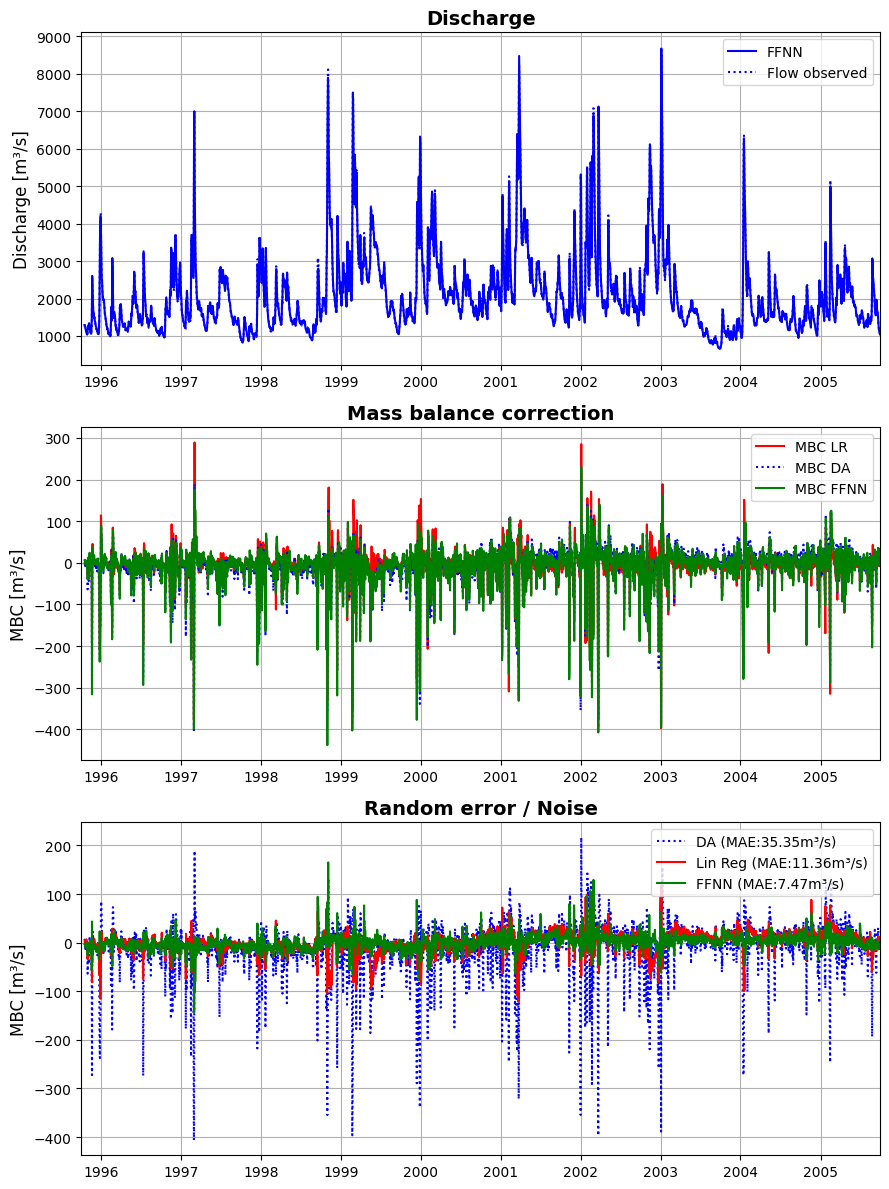

In [323]:

start_date='01/10/1995'
end_date='30/09/2005'
fig.suptitle('               Station:Köln                                                                                Data-driven approach 2', fontsize=13,  x=0.0, ha='left')
start_date_obj = datetime.strptime(start_date, '%d/%m/%Y')
end_date_obj = datetime.strptime(end_date, '%d/%m/%Y')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 12))

ax1.plot(df_plot_val['Date'], df_plot_val['Discharge MIMO FFNN'], label='FFNN', color='blue')
ax1.plot(df_plot_val['Date'], df_plot_val['Flow observed'], label='Flow observed', linestyle='dotted', color='Blue')
ax1.set_title('Discharge', fontsize=14, fontweight='bold')
ax1.set_ylabel('Discharge [m³/s]', fontsize=12)
ax1.set_xlim(start_date_obj, end_date_obj)
ax1.grid(True)
ax1.legend(loc='upper right')

ax2.plot(df_plot_val['Date'], df_plot_val['MBC Lin Reg'], label='MBC LR', color='red')
ax2.plot(df_plot_val['Date'], df_plot_val['MBC DA'], label='MBC DA', color='blue', linestyle='dotted')
ax2.plot(df_plot_val['Date'], df_plot_val['MBC MIMO FFNN'], label='MBC FFNN', color='green')
ax2.set_title('Mass balance correction', fontsize=14, fontweight='bold')
ax2.set_ylabel('MBC [m³/s]', fontsize=12)
ax2.set_xlim(start_date_obj, end_date_obj)
ax2.grid(True)
ax2.legend(loc='upper right')

ax3.plot(df_plot_val['Date'], df_plot_val['MBC DA'], label=f'DA (MAE:{df_mae.iloc[0]['KOELN/MAE']:.2f}m³/s)', color='blue', linestyle='dotted')
ax3.plot(df_plot_val['Date'], df_plot_val['Random error LR'], label=f'Lin Reg (MAE:{df_mae.iloc[0]['KOELN/LR']:.2f}m³/s)', color='red')
ax3.plot(df_plot_val['Date'], df_plot_val['Random error FFNN'], label=f'FFNN (MAE:{mae_dict_FFNN_val['KOELN/flow.bc']:.2f}m³/s)', color='green')
ax3.set_title('Random error / Noise', fontsize=14, fontweight='bold')
ax3.set_ylabel('MBC [m³/s]', fontsize=12)
ax3.set_xlim(start_date_obj, end_date_obj)
ax3.grid(True)
ax3.legend(loc='upper right')

plt.tight_layout()
plt.savefig('02_Köln_Full_time.png')
plt.show()


<h3>Visualization matplotlib format limilted time</h3>

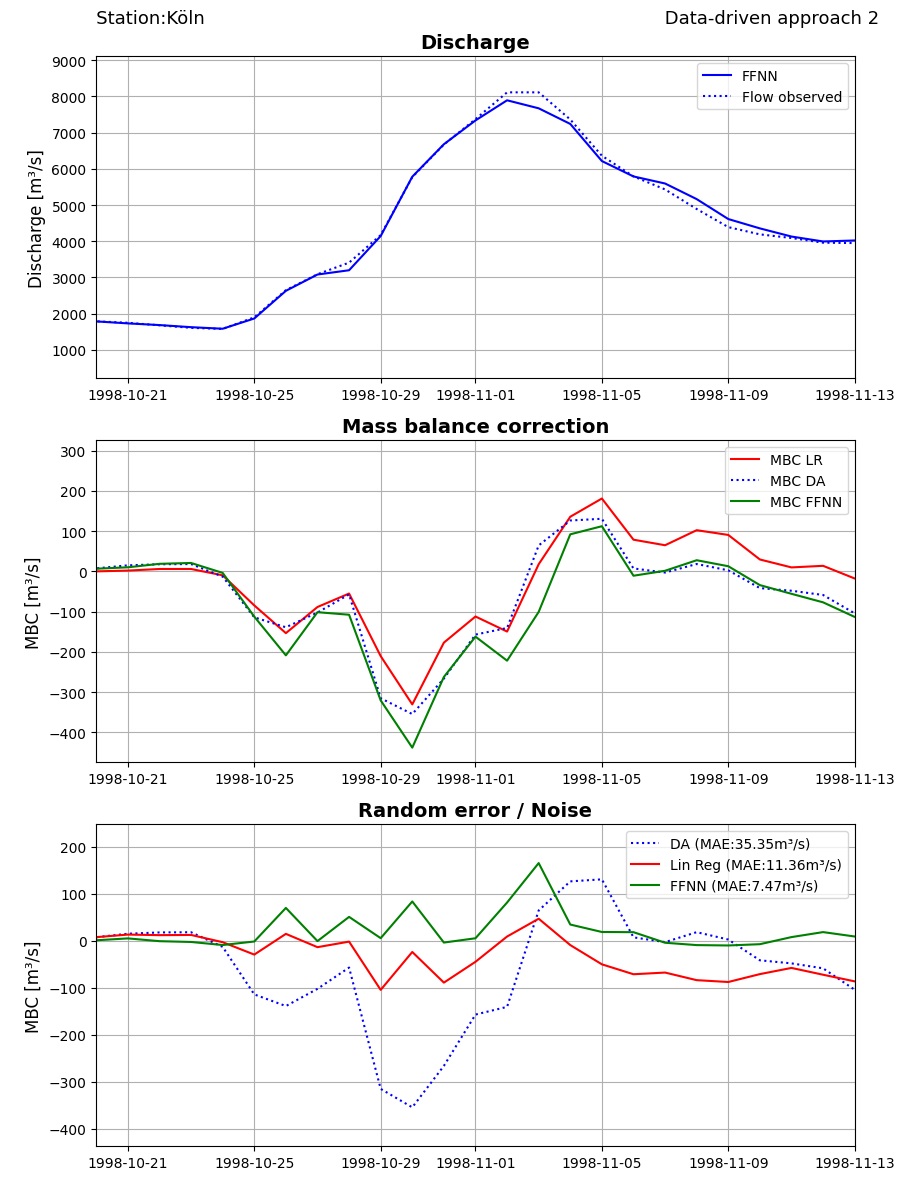

In [324]:

start_date='20/10/1998'
end_date='13/11/1998'

start_date_obj = datetime.strptime(start_date, '%d/%m/%Y')
end_date_obj = datetime.strptime(end_date, '%d/%m/%Y')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 12))
fig.suptitle('               Station:Köln                                                                                Data-driven approach 2', fontsize=13,  x=0.0, ha='left')


ax1.plot(df_plot_val['Date'], df_plot_val['Discharge MIMO FFNN'], label='FFNN', color='blue')
ax1.plot(df_plot_val['Date'], df_plot_val['Flow observed'], label='Flow observed', linestyle='dotted', color='Blue')
ax1.set_title('Discharge', fontsize=14, fontweight='bold')
ax1.set_ylabel('Discharge [m³/s]', fontsize=12)
ax1.set_xlim(start_date_obj, end_date_obj)
ax1.grid(True)
ax1.legend(loc='upper right')

ax2.plot(df_plot_val['Date'], df_plot_val['MBC Lin Reg'], label='MBC LR', color='red')
ax2.plot(df_plot_val['Date'], df_plot_val['MBC DA'], label='MBC DA', color='blue', linestyle='dotted')
ax2.plot(df_plot_val['Date'], df_plot_val['MBC MIMO FFNN'], label='MBC FFNN', color='green')
ax2.set_title('Mass balance correction', fontsize=14, fontweight='bold')
ax2.set_ylabel('MBC [m³/s]', fontsize=12)
ax2.set_xlim(start_date_obj, end_date_obj)
ax2.grid(True)
ax2.legend(loc='upper right')

ax3.plot(df_plot_val['Date'], df_plot_val['MBC DA'], label=f'DA (MAE:{df_mae.iloc[0]['KOELN/MAE']:.2f}m³/s)', color='blue', linestyle='dotted')
ax3.plot(df_plot_val['Date'], df_plot_val['Random error LR'], label=f'Lin Reg (MAE:{df_mae.iloc[0]['KOELN/LR']:.2f}m³/s)', color='red')
ax3.plot(df_plot_val['Date'], df_plot_val['Random error FFNN'], label=f'FFNN (MAE:{mae_dict_FFNN_val['KOELN/flow.bc']:.2f}m³/s)', color='green')
ax3.set_title('Random error / Noise', fontsize=14, fontweight='bold')
ax3.set_ylabel('MBC [m³/s]', fontsize=12)
ax3.set_xlim(start_date_obj, end_date_obj)
ax3.grid(True)
ax3.legend(loc='upper right')

plt.tight_layout()
plt.savefig('08_köln_selected_time_1.png')
plt.show()

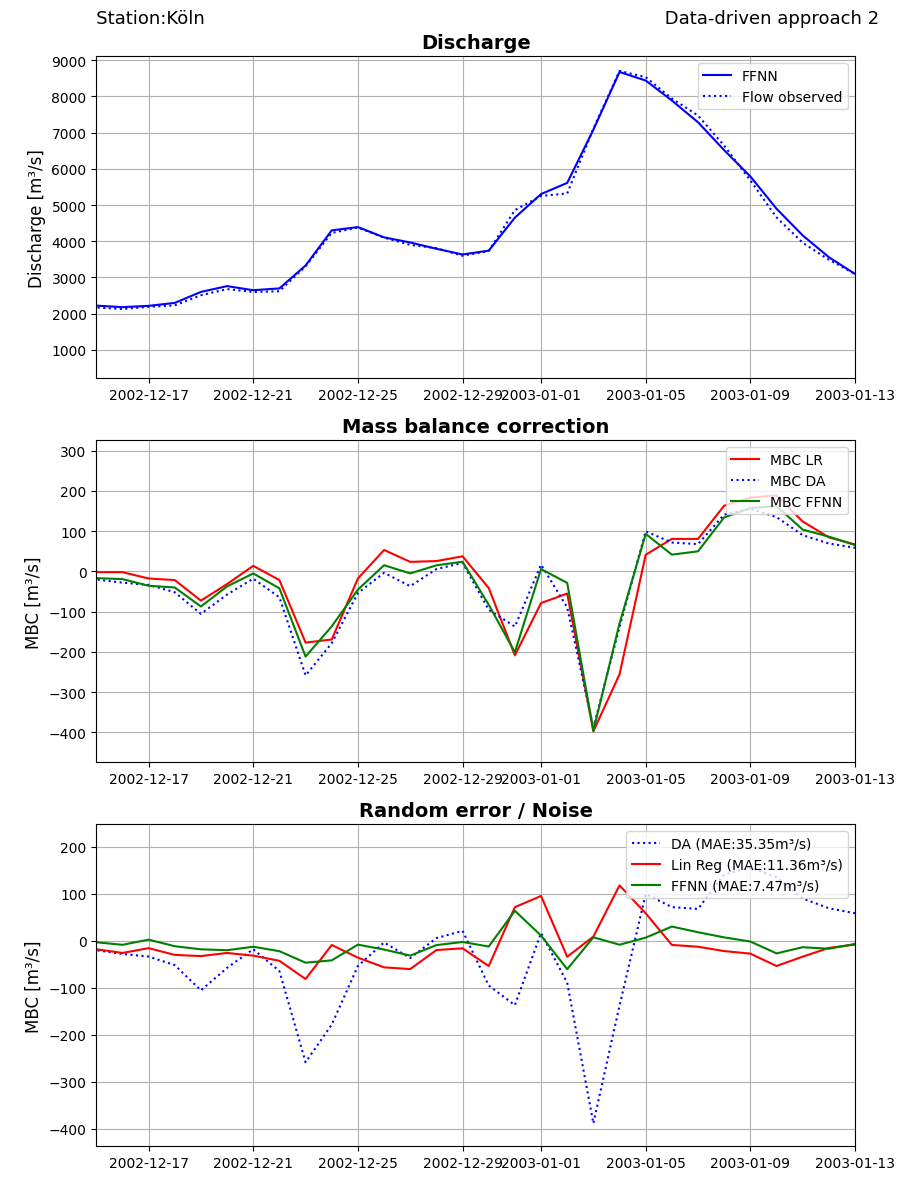

In [325]:

start_date='15/12/2002'
end_date='13/01/2003'

start_date_obj = datetime.strptime(start_date, '%d/%m/%Y')
end_date_obj = datetime.strptime(end_date, '%d/%m/%Y')


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 12))
fig.suptitle('               Station:Köln                                                                                Data-driven approach 2', fontsize=13,  x=0.0, ha='left')

ax1.plot(df_plot_val['Date'], df_plot_val['Discharge MIMO FFNN'], label='FFNN', color='blue')
ax1.plot(df_plot_val['Date'], df_plot_val['Flow observed'], label='Flow observed', linestyle='dotted', color='Blue')
ax1.set_title('Discharge', fontsize=14, fontweight='bold')
ax1.set_ylabel('Discharge [m³/s]', fontsize=12)
ax1.set_xlim(start_date_obj, end_date_obj)
ax1.grid(True)
ax1.legend(loc='upper right')

ax2.plot(df_plot_val['Date'], df_plot_val['MBC Lin Reg'], label='MBC LR', color='red')
ax2.plot(df_plot_val['Date'], df_plot_val['MBC DA'], label='MBC DA', color='blue', linestyle='dotted')
ax2.plot(df_plot_val['Date'], df_plot_val['MBC MIMO FFNN'], label='MBC FFNN', color='green')
ax2.set_title('Mass balance correction', fontsize=14, fontweight='bold')
ax2.set_ylabel('MBC [m³/s]', fontsize=12)
ax2.set_xlim(start_date_obj, end_date_obj)
ax2.grid(True)
ax2.legend(loc='upper right')

ax3.plot(df_plot_val['Date'], df_plot_val['MBC DA'], label=f'DA (MAE:{df_mae.iloc[0]['KOELN/MAE']:.2f}m³/s)', color='blue', linestyle='dotted')
ax3.plot(df_plot_val['Date'], df_plot_val['Random error LR'], label=f'Lin Reg (MAE:{df_mae.iloc[0]['KOELN/LR']:.2f}m³/s)', color='red')
ax3.plot(df_plot_val['Date'], df_plot_val['Random error FFNN'], label=f'FFNN (MAE:{mae_dict_FFNN_val['KOELN/flow.bc']:.2f}m³/s)', color='green')
ax3.set_title('Random error / Noise', fontsize=14, fontweight='bold')
ax3.set_ylabel('MBC [m³/s]', fontsize=12)
ax3.set_xlim(start_date_obj, end_date_obj)
ax3.grid(True)
ax3.legend(loc='upper right')

plt.tight_layout()
plt.savefig('08_Köln_selected_time_2.png')
plt.show()

<h2>Duesseldorf outputs</h2>

In [26]:
i=2

mae_val_lin = mean_absolute_error(y_val.iloc[:,[1]], prediction_linear[i])
mse_val_lin = mean_squared_error(y_val.iloc[:,[1]], prediction_linear[i])


data = {
    'Date': y_val.index,
    'Discharge MIMO FFNN': predictions_rescaled_val[:, 4],
    'Flow observed': np.array(y_val)[:, 4],
    'MBC MIMO FFNN': predictions_rescaled_val[:, 5],
    'MBC Lin Reg': prediction_linear[2],
    'MBC DA': np.array(y_val)[:, 5]
}

df_plot_val = pd.DataFrame(data)
df_plot_val['Random error FFNN'] = df_plot_val['MBC DA'] - df_plot_val['MBC MIMO FFNN']
df_plot_val['Random error LR'] = df_plot_val['MBC DA'] - df_plot_val['MBC Lin Reg']

<h3>Visualization matplotlib format full time</h3>

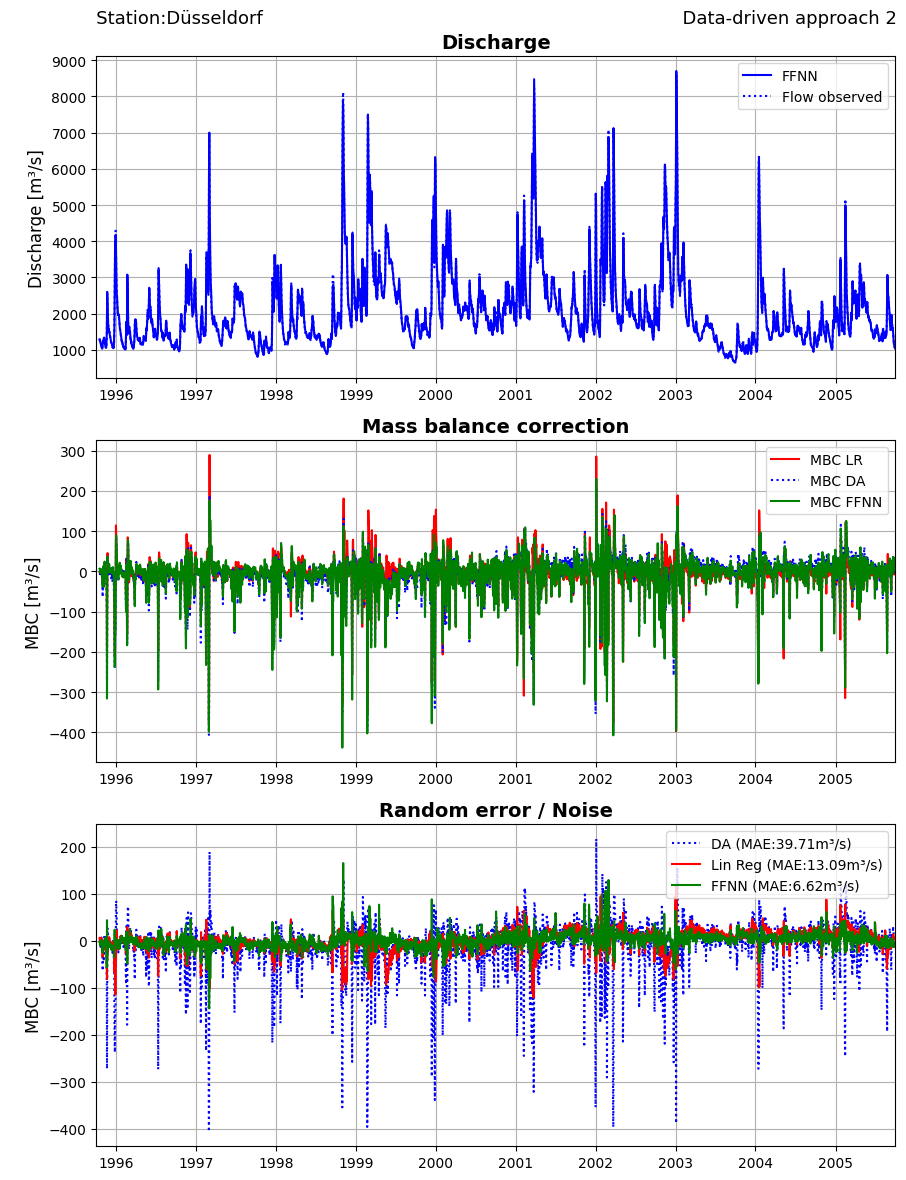

In [327]:

start_date='01/10/1995'
end_date='30/09/2005'

start_date_obj = datetime.strptime(start_date, '%d/%m/%Y')
end_date_obj = datetime.strptime(end_date, '%d/%m/%Y')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 12))
fig.suptitle('               Station:Düsseldorf                                                                         Data-driven approach 2', fontsize=13,  x=0.0, ha='left')

ax1.plot(df_plot_val['Date'], df_plot_val['Discharge MIMO FFNN'], label='FFNN', color='blue')
ax1.plot(df_plot_val['Date'], df_plot_val['Flow observed'], label='Flow observed', linestyle='dotted', color='Blue')
ax1.set_title('Discharge', fontsize=14, fontweight='bold')
ax1.set_ylabel('Discharge [m³/s]', fontsize=12)
ax1.set_xlim(start_date_obj, end_date_obj)
ax1.grid(True)
ax1.legend(loc='upper right')

ax2.plot(df_plot_val['Date'], df_plot_val['MBC Lin Reg'], label='MBC LR', color='red')
ax2.plot(df_plot_val['Date'], df_plot_val['MBC DA'], label='MBC DA', color='blue', linestyle='dotted')
ax2.plot(df_plot_val['Date'], df_plot_val['MBC MIMO FFNN'], label='MBC FFNN', color='green')
ax2.set_title('Mass balance correction', fontsize=14, fontweight='bold')
ax2.set_ylabel('MBC [m³/s]', fontsize=12)
ax2.set_xlim(start_date_obj, end_date_obj)
ax2.grid(True)
ax2.legend(loc='upper right')

ax3.plot(df_plot_val['Date'], df_plot_val['MBC DA'], label=f'DA (MAE:{df_mae.iloc[0]['DUESS/MAE']:.2f}m³/s)', color='blue', linestyle='dotted')
ax3.plot(df_plot_val['Date'], df_plot_val['Random error LR'], label=f'Lin Reg (MAE:{df_mae.iloc[0]['DUESS/LR']:.2f}m³/s)', color='red')
ax3.plot(df_plot_val['Date'], df_plot_val['Random error FFNN'], label=f'FFNN (MAE:{mae_dict_FFNN_val['DUESS/flow.bc']:.2f}m³/s)', color='green')
ax3.set_title('Random error / Noise', fontsize=14, fontweight='bold')
ax3.set_ylabel('MBC [m³/s]', fontsize=12)
ax3.set_xlim(start_date_obj, end_date_obj)
ax3.grid(True)
ax3.legend(loc='upper right')

plt.tight_layout()
plt.savefig('03_Duesseldorf_Full_time.png')
plt.show()


<h3>Visualization matplotlib format limilted time</h3>

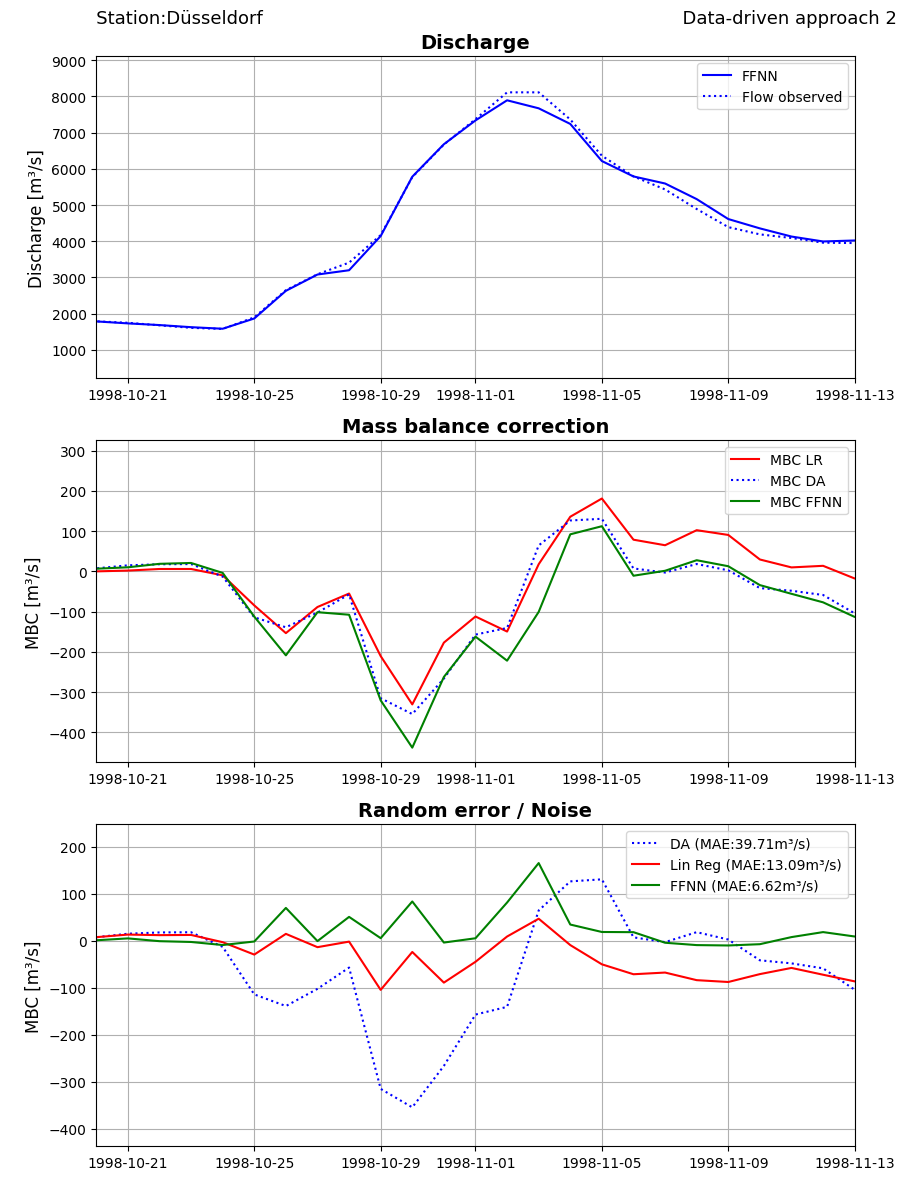

In [328]:

start_date='20/10/1998'
end_date='13/11/1998'

start_date_obj = datetime.strptime(start_date, '%d/%m/%Y')
end_date_obj = datetime.strptime(end_date, '%d/%m/%Y')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 12))
fig.suptitle('               Station:Düsseldorf                                                                         Data-driven approach 2', fontsize=13,  x=0.0, ha='left')

ax1.plot(df_plot_val['Date'], df_plot_val['Discharge MIMO FFNN'], label='FFNN', color='blue')
ax1.plot(df_plot_val['Date'], df_plot_val['Flow observed'], label='Flow observed', linestyle='dotted', color='Blue')
ax1.set_title('Discharge', fontsize=14, fontweight='bold')
ax1.set_ylabel('Discharge [m³/s]', fontsize=12)
ax1.set_xlim(start_date_obj, end_date_obj)
ax1.grid(True)
ax1.legend(loc='upper right')

ax2.plot(df_plot_val['Date'], df_plot_val['MBC Lin Reg'], label='MBC LR', color='red')
ax2.plot(df_plot_val['Date'], df_plot_val['MBC DA'], label='MBC DA', color='blue', linestyle='dotted')
ax2.plot(df_plot_val['Date'], df_plot_val['MBC MIMO FFNN'], label='MBC FFNN', color='green')
ax2.set_title('Mass balance correction', fontsize=14, fontweight='bold')
ax2.set_ylabel('MBC [m³/s]', fontsize=12)
ax2.set_xlim(start_date_obj, end_date_obj)
ax2.grid(True)
ax2.legend(loc='upper right')

ax3.plot(df_plot_val['Date'], df_plot_val['MBC DA'], label=f'DA (MAE:{df_mae.iloc[0]['DUESS/MAE']:.2f}m³/s)', color='blue', linestyle='dotted')
ax3.plot(df_plot_val['Date'], df_plot_val['Random error LR'], label=f'Lin Reg (MAE:{df_mae.iloc[0]['DUESS/LR']:.2f}m³/s)', color='red')
ax3.plot(df_plot_val['Date'], df_plot_val['Random error FFNN'], label=f'FFNN (MAE:{mae_dict_FFNN_val['DUESS/flow.bc']:.2f}m³/s)', color='green')
ax3.set_title('Random error / Noise', fontsize=14, fontweight='bold')
ax3.set_ylabel('MBC [m³/s]', fontsize=12)
ax3.set_xlim(start_date_obj, end_date_obj)
ax3.grid(True)
ax3.legend(loc='upper right')

plt.tight_layout()
plt.savefig('09_Duesseldorf_selected_time_1.png')
plt.show()

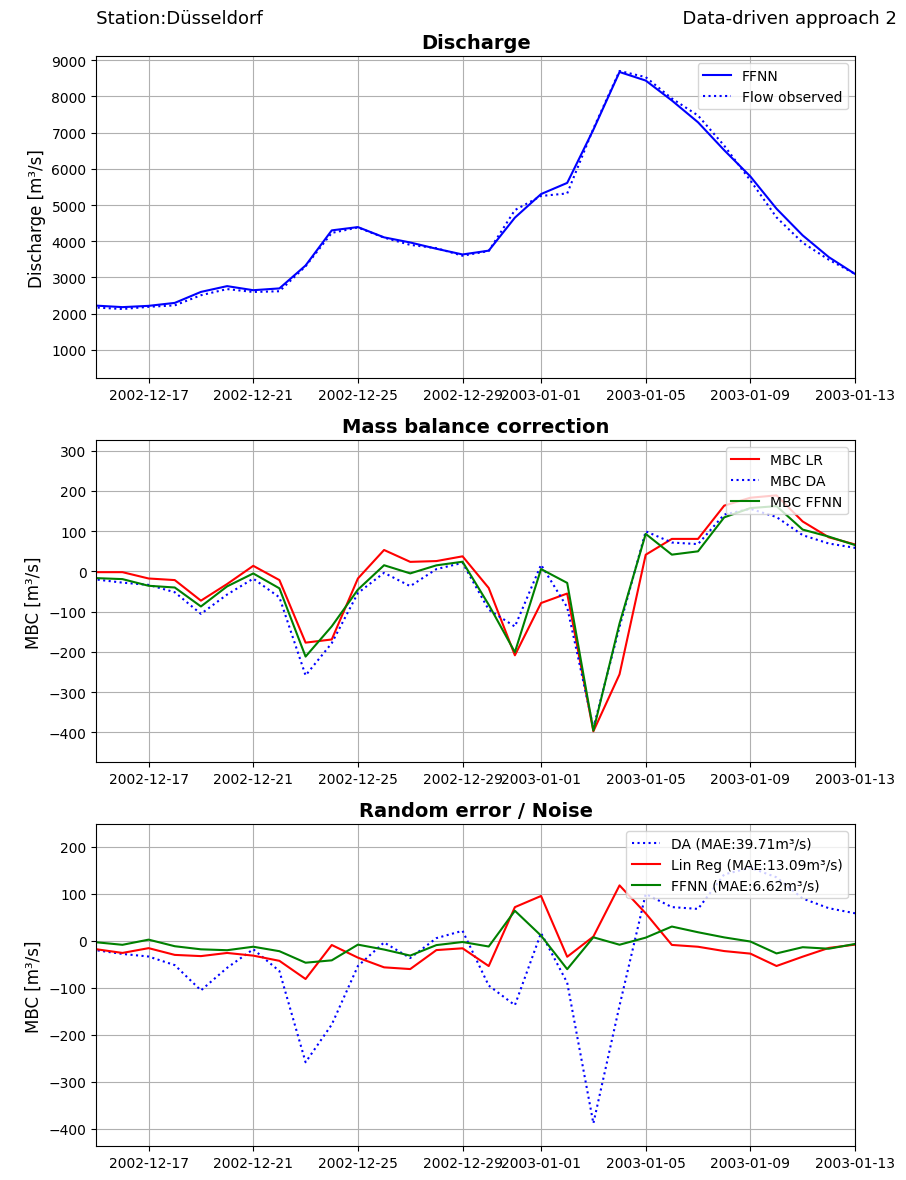

In [329]:

start_date='15/12/2002'
end_date='13/01/2003'

start_date_obj = datetime.strptime(start_date, '%d/%m/%Y')
end_date_obj = datetime.strptime(end_date, '%d/%m/%Y')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 12))
fig.suptitle('               Station:Düsseldorf                                                                         Data-driven approach 2', fontsize=13,  x=0.0, ha='left')

ax1.plot(df_plot_val['Date'], df_plot_val['Discharge MIMO FFNN'], label='FFNN', color='blue')
ax1.plot(df_plot_val['Date'], df_plot_val['Flow observed'], label='Flow observed', linestyle='dotted', color='Blue')
ax1.set_title('Discharge', fontsize=14, fontweight='bold')
ax1.set_ylabel('Discharge [m³/s]', fontsize=12)
ax1.set_xlim(start_date_obj, end_date_obj)
ax1.grid(True)
ax1.legend(loc='upper right')

ax2.plot(df_plot_val['Date'], df_plot_val['MBC Lin Reg'], label='MBC LR', color='red')
ax2.plot(df_plot_val['Date'], df_plot_val['MBC DA'], label='MBC DA', color='blue', linestyle='dotted')
ax2.plot(df_plot_val['Date'], df_plot_val['MBC MIMO FFNN'], label='MBC FFNN', color='green')
ax2.set_title('Mass balance correction', fontsize=14, fontweight='bold')
ax2.set_ylabel('MBC [m³/s]', fontsize=12)
ax2.set_xlim(start_date_obj, end_date_obj)
ax2.grid(True)
ax2.legend(loc='upper right')

ax3.plot(df_plot_val['Date'], df_plot_val['MBC DA'], label=f'DA (MAE:{df_mae.iloc[0]['DUESS/MAE']:.2f}m³/s)', color='blue', linestyle='dotted')
ax3.plot(df_plot_val['Date'], df_plot_val['Random error LR'], label=f'Lin Reg (MAE:{df_mae.iloc[0]['DUESS/LR']:.2f}m³/s)', color='red')
ax3.plot(df_plot_val['Date'], df_plot_val['Random error FFNN'], label=f'FFNN (MAE:{mae_dict_FFNN_val['DUESS/flow.bc']:.2f}m³/s)', color='green')
ax3.set_title('Random error / Noise', fontsize=14, fontweight='bold')
ax3.set_ylabel('MBC [m³/s]', fontsize=12)
ax3.set_xlim(start_date_obj, end_date_obj)
ax3.grid(True)
ax3.legend(loc='upper right')

plt.tight_layout()
plt.savefig('09_Duesseldorf_selected_time_2.png')
plt.show()

<h1>Random error plot</h1>

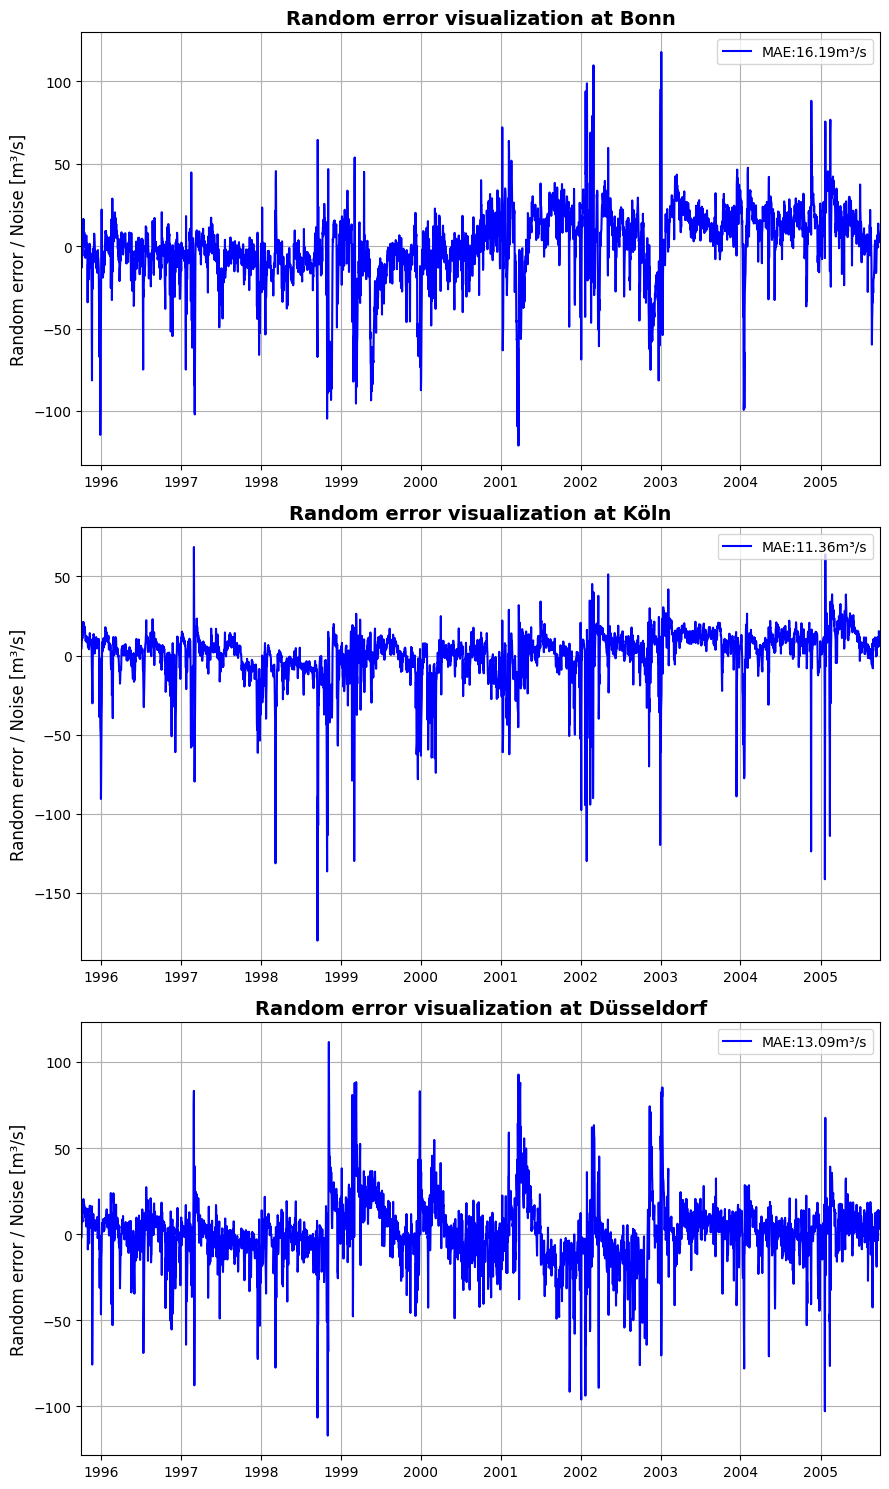

In [336]:
start_date='01/10/1995'
end_date='30/09/2005'

start_date_obj = datetime.strptime(start_date, '%d/%m/%Y')
end_date_obj = datetime.strptime(end_date, '%d/%m/%Y')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 15))

ax1.plot(df['Date'], df['BONN/LR'], label=f'MAE:{df_mae.iloc[0]['BONN/LR']:.2f}m³/s', color='blue')
ax1.set_title('Random error visualization at Bonn', fontsize=14, fontweight='bold')
ax1.set_ylabel('Random error / Noise [m³/s]', fontsize=12)
ax1.set_xlim(start_date_obj, end_date_obj)
ax1.grid(True)
ax1.legend(loc='upper right')

ax2.plot(df['Date'], df['KOELN/LR'], label=f'MAE:{df_mae.iloc[0]['KOELN/LR']:.2f}m³/s', color='blue')
ax2.set_title('Random error visualization at Köln', fontsize=14, fontweight='bold')
ax2.set_ylabel('Random error / Noise [m³/s]', fontsize=12)
ax2.set_xlim(start_date_obj, end_date_obj)
ax2.grid(True)
ax2.legend(loc='upper right')

ax3.plot(df['Date'], df['DUESS/LR'], label=f'MAE:{df_mae.iloc[0]['DUESS/LR']:.2f}m³/s', color='blue')
ax3.set_title('Random error visualization at Düsseldorf', fontsize=14, fontweight='bold')
ax3.set_ylabel('Random error / Noise [m³/s]', fontsize=12)
ax3.set_xlim(start_date_obj, end_date_obj)
ax3.grid(True)
ax3.legend(loc='upper right')

plt.tight_layout()
plt.savefig('random_error_plot_approach2_3_stations.png')
plt.show()

<h1>Visualization matplotlib format collection subplots</h1>

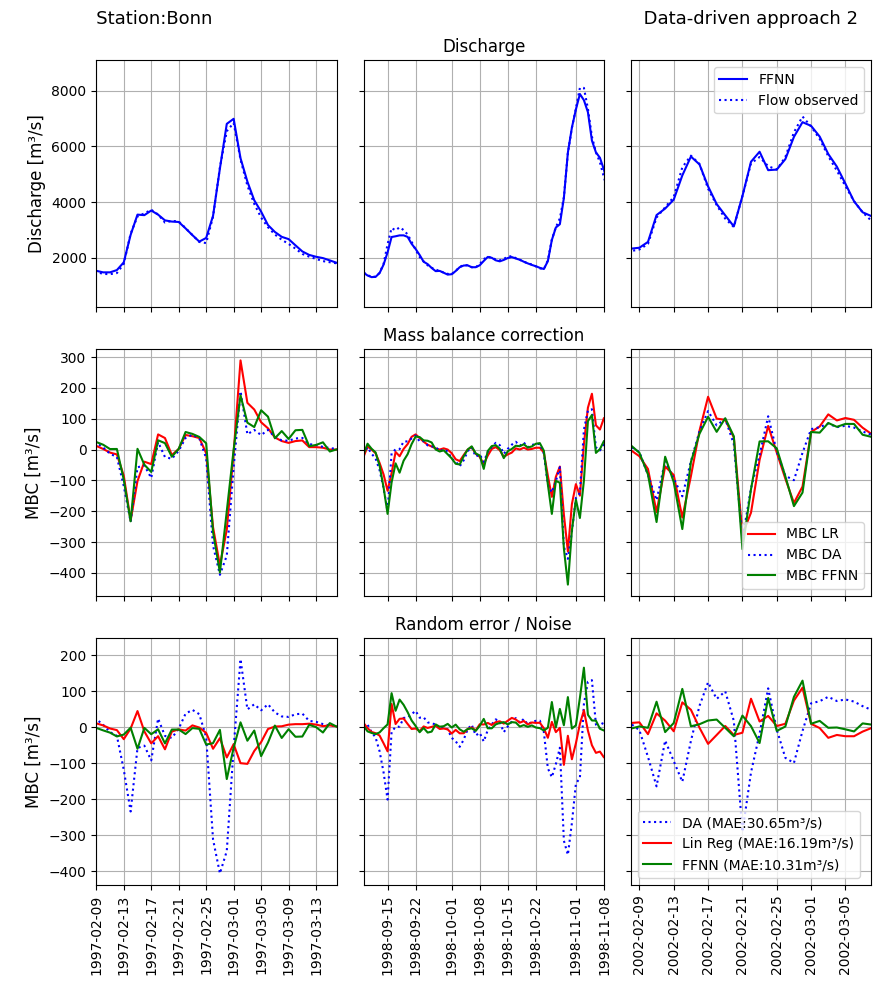

In [391]:
fig, ((ax1, ax4, ax7),(ax2, ax5, ax8),(ax3, ax6, ax9)) = plt.subplots(3, 3, figsize=(9, 10))
fig.suptitle('               Station:Bonn                                                                           Data-driven approach 2', fontsize=13,  x=0.0, ha='left')

start_date='09/02/1997'
end_date='16/03/1997'
start_date_obj = datetime.strptime(start_date, '%d/%m/%Y')
end_date_obj = datetime.strptime(end_date, '%d/%m/%Y')

ax1.plot(df_plot_val['Date'], df_plot_val['Discharge MIMO FFNN'], label='FFNN', color='blue')
ax1.plot(df_plot_val['Date'], df_plot_val['Flow observed'], label='Flow observed', linestyle='dotted', color='Blue')
ax1.set_ylabel('Discharge [m³/s]', fontsize=12)
ax1.set_xlim(start_date_obj, end_date_obj)
ax1.set_xticklabels([])
ax1.grid()

ax2.plot(df_plot_val['Date'], df_plot_val['MBC Lin Reg'], label='MBC LR', color='red')
ax2.plot(df_plot_val['Date'], df_plot_val['MBC DA'], label='MBC DA', color='blue', linestyle='dotted')
ax2.plot(df_plot_val['Date'], df_plot_val['MBC MIMO FFNN'], label='MBC FFNN', color='green')
ax2.set_ylabel('MBC [m³/s]', fontsize=12)
ax2.set_xlim(start_date_obj, end_date_obj)
ax2.set_xticklabels([])
ax2.grid()

ax3.plot(df_plot_val['Date'], df_plot_val['MBC DA'], label=f'DA (MAE:{df_mae.iloc[0]['BONN/MAE']:.2f}m³/s)', color='blue', linestyle='dotted')
ax3.plot(df_plot_val['Date'], df_plot_val['Random error LR'], label=f'Lin Reg (MAE:{df_mae.iloc[0]['BONN/LR']:.2f}m³/s)', color='red')
ax3.plot(df_plot_val['Date'], df_plot_val['Random error FFNN'], label=f'FFNN (MAE:{mae_dict_FFNN_val['BONN/flow.bc']:.2f}m³/s)', color='green')
ax3.set_ylabel('MBC [m³/s]', fontsize=12)
ax3.set_xlim(start_date_obj, end_date_obj)
ax3.grid()
ax3.tick_params(axis='x', labelrotation=90)

start_date='09/09/1998'
end_date='08/11/1998'
start_date_obj = datetime.strptime(start_date, '%d/%m/%Y')
end_date_obj = datetime.strptime(end_date, '%d/%m/%Y')

ax4.plot(df_plot_val['Date'], df_plot_val['Discharge MIMO FFNN'], label='FFNN', color='blue')
ax4.plot(df_plot_val['Date'], df_plot_val['Flow observed'], label='Flow observed', linestyle='dotted', color='Blue')
ax4.set_title('Discharge', fontsize=12)
ax4.set_xlim(start_date_obj, end_date_obj)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.grid()

ax5.plot(df_plot_val['Date'], df_plot_val['MBC Lin Reg'], label='MBC LR', color='red')
ax5.plot(df_plot_val['Date'], df_plot_val['MBC DA'], label='MBC DA', color='blue', linestyle='dotted')
ax5.plot(df_plot_val['Date'], df_plot_val['MBC MIMO FFNN'], label='MBC FFNN', color='green')
ax5.set_title('Mass balance correction', fontsize=12)
ax5.set_xlim(start_date_obj, end_date_obj)
ax5.set_xticklabels([])
ax5.set_yticklabels([])
ax5.grid()

ax6.plot(df_plot_val['Date'], df_plot_val['MBC DA'], label=f'DA (MAE:{df_mae.iloc[0]['BONN/MAE']:.2f}m³/s)', color='blue', linestyle='dotted')
ax6.plot(df_plot_val['Date'], df_plot_val['Random error LR'], label=f'Lin Reg (MAE:{df_mae.iloc[0]['BONN/LR']:.2f}m³/s)', color='red')
ax6.plot(df_plot_val['Date'], df_plot_val['Random error FFNN'], label=f'FFNN (MAE:{mae_dict_FFNN_val['BONN/flow.bc']:.2f}m³/s)', color='green')
ax6.set_title('Random error / Noise', fontsize=12)
ax6.set_xlim(start_date_obj, end_date_obj)
ax6.grid()
ax6.set_yticklabels([])
ax6.tick_params(axis='x', labelrotation=90)

start_date='08/02/2002'
end_date='08/03/2002'
start_date_obj = datetime.strptime(start_date, '%d/%m/%Y')
end_date_obj = datetime.strptime(end_date, '%d/%m/%Y')

ax7.plot(df_plot_val['Date'], df_plot_val['Discharge MIMO FFNN'], label='FFNN', color='blue')
ax7.plot(df_plot_val['Date'], df_plot_val['Flow observed'], label='Flow observed', linestyle='dotted', color='Blue')
ax7.set_xlim(start_date_obj, end_date_obj)
ax7.set_xticklabels([])
ax7.set_yticklabels([])
ax7.grid()
ax7.legend()

ax8.plot(df_plot_val['Date'], df_plot_val['MBC Lin Reg'], label='MBC LR', color='red')
ax8.plot(df_plot_val['Date'], df_plot_val['MBC DA'], label='MBC DA', color='blue', linestyle='dotted')
ax8.plot(df_plot_val['Date'], df_plot_val['MBC MIMO FFNN'], label='MBC FFNN', color='green')
ax8.set_xlim(start_date_obj, end_date_obj)
ax8.set_xticklabels([])
ax8.set_yticklabels([])
ax8.grid()
ax8.legend()

ax9.plot(df_plot_val['Date'], df_plot_val['MBC DA'], label=f'DA (MAE:{df_mae.iloc[0]['BONN/MAE']:.2f}m³/s)', color='blue', linestyle='dotted')
ax9.plot(df_plot_val['Date'], df_plot_val['Random error LR'], label=f'Lin Reg (MAE:{df_mae.iloc[0]['BONN/LR']:.2f}m³/s)', color='red')
ax9.plot(df_plot_val['Date'], df_plot_val['Random error FFNN'], label=f'FFNN (MAE:{mae_dict_FFNN_val['BONN/flow.bc']:.2f}m³/s)', color='green')
ax9.set_xlim(start_date_obj, end_date_obj)
ax9.grid()
ax9.set_yticklabels([])
ax9.legend()
ax9.tick_params(axis='x', labelrotation=90)

# for ax in fig.get_axes():
#     ax.label_outer()

plt.tight_layout()
plt.savefig('01_Bonn_extremes_time.png')
plt.show()
